In [ ]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [97]:
male = open('../data/polish-male-firstnames.txt').read().splitlines()
female = open('../data/polish-female-firstnames.txt').read().splitlines()
words = male + female
words = [w.strip().lower() for w in words]

words[:5]

['jan', 'stanisław', 'andrzej', 'józef', 'tadeusz']

In [98]:
all_chars = sorted(list(set(''.join(words))))
all_chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y',
 'z',
 'ó',
 'ę',
 'ł',
 'ń',
 'ś',
 'ż']

In [99]:
stoi = { s:i+1 for i,s in enumerate(all_chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
char_size = len(stoi.items())
char_size

31

In [446]:
BLOCK_SIZE = 4 # context of 4 letters

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(10)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [447]:
(Xtr.shape, Xdev.shape, Xte.shape)

(torch.Size([3745, 4]), torch.Size([481, 4]), torch.Size([478, 4]))

In [569]:
# MLP

EMBED_SIZE = 3
FIRST_LAYER_SIZE = 50
BATCH_SIZE = 16

g = torch.Generator().manual_seed(2147483647)

# embeding
C = torch.randn((char_size, EMBED_SIZE), generator=g)

# first layer
W1 = torch.randn((BLOCK_SIZE * EMBED_SIZE, FIRST_LAYER_SIZE), generator=g)
b1 = torch.randn(FIRST_LAYER_SIZE, generator=g)

# second layer
W2 = torch.randn((FIRST_LAYER_SIZE, char_size), generator=g)
b2 = torch.randn(char_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [570]:
sum(p.nelement() for p in parameters) # number of parameters of this MLP

2324

In [571]:
for p in parameters:
    p.requires_grad = True

In [572]:
lre = torch.linspace(-3, 0, 2000)
lrs = 10**lre

In [573]:
lossi = []

steps = 10000
for i in range(steps):

    # batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, BLOCK_SIZE * EMBED_SIZE) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    lossi.append(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 0.6 * steps else 0.01
    for p in parameters:
        p.data += -lr * p.grad

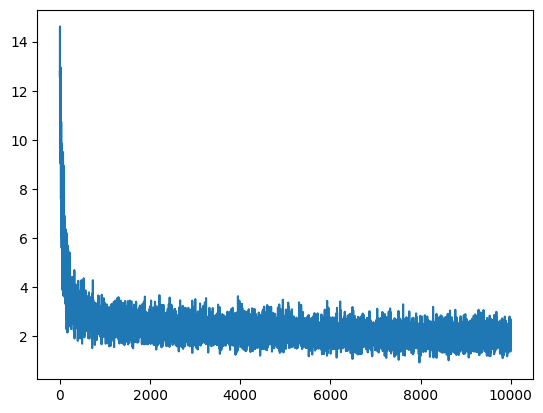

In [574]:
plt.plot(list(range(len(lossi))), lossi)

In [575]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, BLOCK_SIZE * EMBED_SIZE) @ W1 + b1) 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0082, grad_fn=<NllLossBackward0>)

In [576]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, BLOCK_SIZE * EMBED_SIZE) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3199, grad_fn=<NllLossBackward0>)

In [577]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

czerta.
leże.
alicc.
alfemar.
galisława.
kulw.
reumalderjana.
miszil.
rareniaji.
wera.
wilino.
gyrowinientyr.
sławaj.
caazbienalina.
olbyj.
wila.
larfa.
mulla.
arolia.
herżeusa.


In [578]:
# final loss based on test set
emb = C[Xte] 
h = torch.tanh(emb.view(-1, BLOCK_SIZE * EMBED_SIZE) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4550, grad_fn=<NllLossBackward0>)